# Домашка 
---------------------------------------    
Этот ноутбук является частью дз Deep Learning School. Остальные ноутбуки можно найти на https://github.com/Sankek/DLS_GAN_HW.

В данном ноутбуке я пытаюсь возпроизвести результаты оригинальной статьи по ГАНам https://arxiv.org/abs/1406.2661. 

---------------------------------------


# Simle GAN

In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from IPython.display import clear_output

In [ ]:
!nvidia-smi
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device: {DEVICE}")

Tue Jan  5 12:06:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Воспроизводимость результатов
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

## Dataset MNIST

Скачавание и подготовка датасета

In [ ]:
data_transforms = transforms.Compose([
  transforms.ToTensor(),
])

root = './'
train = datasets.MNIST(root, train=True,  transform=data_transforms, download=True)

IMAGE_SIZE = 28

In [ ]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, drop_last=True, shuffle=True)

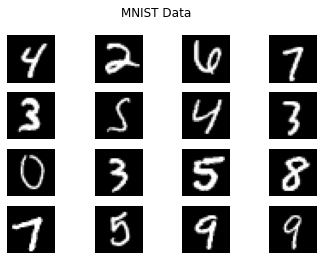

In [ ]:
fig, ax = plt.subplots(4, 4)

data_iter = iter(train_loader)

for i in range(4*4):
  plt.subplot(4, 4, i+1)
  plt.imshow(next(data_iter)[0][0][0].detach().numpy(), cmap='gray')
  plt.axis('off')
  plt.suptitle('MNIST Data')
plt.show()

## Setting up the model

Архитектура частично взята из https://github.com/togheppi/vanilla_GAN/blob/master/MNIST_GAN_pytorch.py

In [ ]:
# размер вектора шума (latent space)
noise_vector_size = 16

In [ ]:
class GeneratorNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc = nn.Sequential(
        nn.Linear(noise_vector_size, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, IMAGE_SIZE*IMAGE_SIZE),
    )


  def forward(self, x):
    out = self.fc(x)
    out = out.unflatten(1, (1, IMAGE_SIZE, IMAGE_SIZE))

    return out

In [ ]:
class DiscriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc = nn.Sequential(
        nn.Linear(IMAGE_SIZE*IMAGE_SIZE, 1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(256, 1),
    )

  def forward(self, x):
    out = x.view(x.shape[0], -1)
    out = self.fc(out)
    return out

In [ ]:
# генерация вектора шума
def random_noise_vectors(n):
  return torch.rand(n, noise_vector_size, device=DEVICE)*10

In [ ]:
def train(D_model, G_model, D_loss_fn, G_loss_fn, D_optim, G_optim, data, epochs=20):
  # генерация векторов, на которых будет генериться картинка для графика во время обучения
  z1 = random_noise_vectors(1)
  z2 = random_noise_vectors(1)
  z3 = random_noise_vectors(1)
  z4 = random_noise_vectors(1)
  z = [z1, z2, z3, z4]

  D_losses = []
  G_losses = []

  for epoch in range(epochs):
    D_run_loss = 0
    G_run_loss = 0

    for X_batch, _ in data:
      Z_batch = random_noise_vectors(batch_size)
      assert Z_batch.shape[0] == X_batch.shape[0]
      X_batch = X_batch.to(DEVICE)

      y_ones = torch.ones(X_batch.shape[0], 1, device=DEVICE)
      y_zeros = torch.zeros(X_batch.shape[0], 1, device=DEVICE)
      criterion = nn.BCEWithLogitsLoss()
      
      D_model.train()
      G_model.eval()
      D_loss = criterion(D_model(X_batch), y_ones) + criterion(D_model(G_model(Z_batch).detach()), y_zeros)
      D_optim.zero_grad()
      D_loss.backward()
      D_optim.step()
      D_run_loss += D_loss.item()

      Z_batch = random_noise_vectors(batch_size)

      G_model.train()
      D_model.eval()
      G_loss = criterion(D_model(G_model(Z_batch)), y_ones)
      G_optim.zero_grad()
      G_loss.backward()
      G_optim.step()
      G_run_loss += G_loss.item()

    D_run_loss = D_run_loss/len(data)
    G_run_loss = G_run_loss/len(data)
    D_losses += [D_run_loss]
    G_losses += [G_run_loss]

    clear_output(wait=True)
    fig, ax = plt.subplots(1, 4, figsize=(8, 4))

    G_model.eval()
    for i in range(4):
      plt.subplot(1, 4, i+1)
      gen_im = G_model(z[i])
      plt.suptitle(f"Epoch {epoch}: D_loss {round(D_run_loss, 2)}, G_loss {round(G_run_loss, 2)}")
      plt.imshow(gen_im[0][0].cpu().detach().numpy(), cmap='gray')
      plt.title('Generated Image')
      plt.axis('off')
    fig.tight_layout(pad=2)
    plt.show()
    
  return D_losses, G_losses


In [ ]:
#
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Далее такой же цикл обуения как и выше, но с сохранением картинок для того, чтобы сделать видео процесса обучения
SAVE_PATH = '/content/drive/MyDrive/gan_images'

In [ ]:
def train_animated(D_model, G_model, D_loss_fn, G_loss_fn, D_optim, G_optim, data, epochs=20):
  data_len = len(data)
  saved_batches = 0
  z1 = random_noise_vectors(1)
  z2 = random_noise_vectors(1)
  z3 = random_noise_vectors(1)
  z4 = random_noise_vectors(1)
  z = [z1, z2, z3, z4]

  D_losses = []
  G_losses = []

  fig, ax = plt.subplots(1, 4, figsize=(8, 4))
  fig.tight_layout(pad=2)


  for epoch in range(epochs):
    D_run_loss = 0
    G_run_loss = 0

    for batch_num, (X_batch, _) in enumerate(data):
      D_run_loss = 0  
      G_run_loss = 0

      Z_batch = random_noise_vectors(batch_size)
      assert Z_batch.shape[0] == X_batch.shape[0]
      X_batch = X_batch.to(DEVICE)

      y_ones = torch.ones(X_batch.shape[0], 1, device=DEVICE)
      y_zeros = torch.zeros(X_batch.shape[0], 1, device=DEVICE)
      criterion = nn.BCEWithLogitsLoss()
      


      D_model.train()
      G_model.eval()
      D_loss = criterion(D_model(X_batch), y_ones) + criterion(D_model(G_model(Z_batch).detach()), y_zeros)
      D_optim.zero_grad()
      D_loss.backward()
      D_optim.step()
      D_run_loss += D_loss.item()

      Z_batch = random_noise_vectors(batch_size)

      G_model.train()
      D_model.eval()
      G_loss = criterion(D_model(G_model(Z_batch)), y_ones)
      G_optim.zero_grad()
      G_loss.backward()
      G_optim.step()
      G_run_loss += G_loss.item()


      D_losses += [D_run_loss]
      G_losses += [G_run_loss]

      current_batch = epoch*data_len+batch_num+1

      if current_batch % 200 == 0:
        clear_output(wait=True)
        print(f"Processing {current_batch}/{epochs*data_len} batch...")
        
        saved_batches += 1
        G_model.eval()
        for i in range(4):
          plt.subplot(1, 4, i+1)
          gen_im = G_model(z[i])
          plt.suptitle(f"Epoch {epoch}: D_loss {round(D_run_loss, 2)}, G_loss {round(G_run_loss, 2)}\n Batch: {epoch*data_len+batch_num+1}/{epochs*data_len}")
          plt.imshow(gen_im[0][0].cpu().detach().numpy(), cmap='gray')
          plt.title('Generated Image')
          plt.axis('off')
        plt.savefig(f'{SAVE_PATH}/{saved_batches}.jpg', quality=50)
    

  return D_losses, G_losses


## Training

In [ ]:
losses = [[], []]

D_model = DiscriminatorNet().to(DEVICE)
G_model = GeneratorNet().to(DEVICE)

D_optim = torch.optim.Adam(D_model.parameters(), lr=5e-5)
G_optim = torch.optim.Adam(G_model.parameters(), lr=5e-5)

Processing 187400/187400 batch...


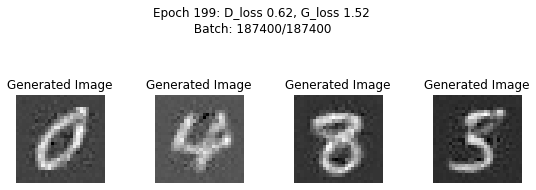

In [ ]:
d_loss, g_loss = train_animated(D_model, G_model, discriminator_loss, 
                       generator_loss, D_optim, G_optim, train_loader, epochs=200)
losses[0] += d_loss
losses[1] += g_loss

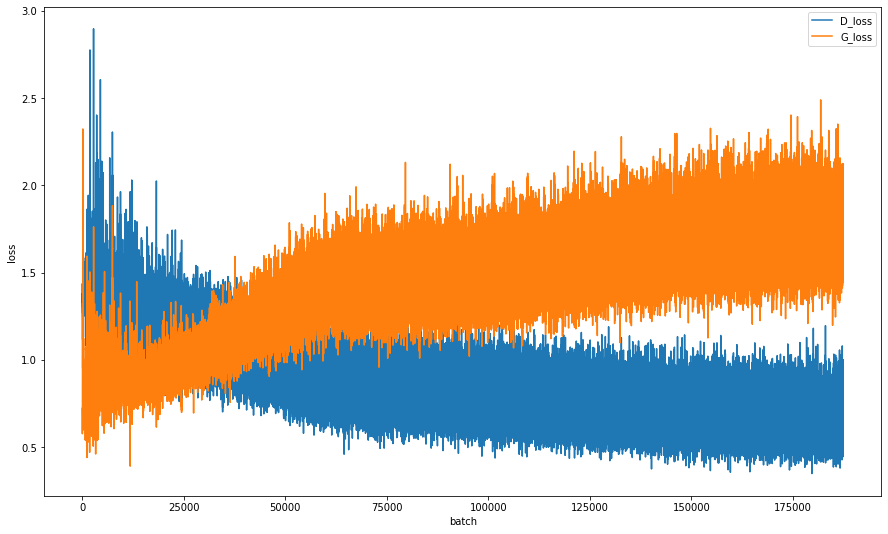

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(losses[0], label="D_loss")
plt.plot(losses[1], label="G_loss")
plt.legend(loc='best')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

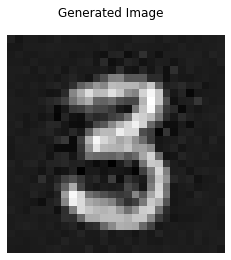

tensor([[4.3102, 8.0090, 6.1714, 7.9554, 8.5681, 2.4918, 9.2765, 2.1632, 8.9605,
         4.8249, 9.9364, 8.1221, 6.8438, 6.1774, 8.7353, 9.7730]],
       device='cuda:0')


In [ ]:
# Теперь можно попробовать различные вектора шума и посмотреть какие картинки получаются

z = random_noise_vectors(1)
# z = torch.ones(1, noise_vector_size).to(DEVICE)
# z = (torch.zeros(1, noise_vector_size)+ 5).to(DEVICE)

plt.subplot(1, 1, 1)
gen_im = G_model(z)
plt.suptitle(f"Generated Image")
plt.imshow(gen_im[0][0].cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

print(z)

In [ ]:
z_1 = random_noise_vectors(1)
z_2 = random_noise_vectors(1)
z_3 = random_noise_vectors(1)

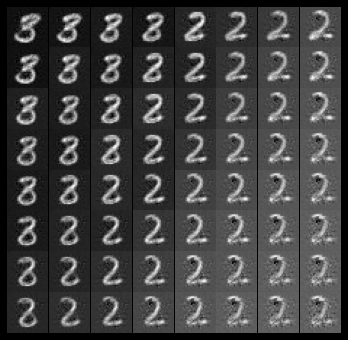

In [ ]:
fig, ax = plt.subplots(8, 8, figsize=(6, 6))

G_model.eval()
for m in range(8):
  for n in range(8):
    z = z_1+(m/7)*(z_2-z_1)+(n/7)*(z_3-z_1)
    plt.subplot(8, 8, m*8+n+1)
    gen_im = G_model(z)
    # plt.suptitle(f"Some text")
    plt.imshow(gen_im[0][0].cpu().detach().numpy(), cmap='gray')
    # plt.title('Gen Image')
    plt.axis('off')
    ax[1, 1].set_facecolor((0, 0, 0))
plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)
fig.patch.set_facecolor((0, 0, 0))


plt.show()

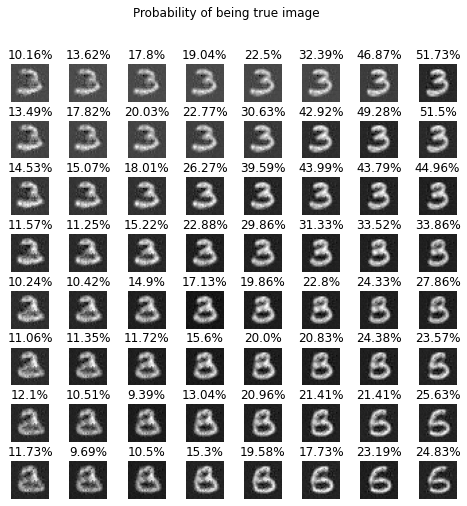

In [ ]:
# Здесь также показаны вероятности, выдаваемые дискриминатором на сгенерированных изображениях

fig, ax = plt.subplots(8, 8, figsize=(8, 8))

G_model.eval()
for m in range(8):
  for n in range(8):
    z = z_1+(m/7)*(z_2-z_1)+(n/7)*(z_3-z_1)
    p = f"{round(torch.sigmoid(D_model(G_model(z))).item()*100, 2)}%"
    plt.subplot(8, 8, m*8+n+1)
    gen_im = G_model(z)
    plt.suptitle(f"Probability of being true image")
    plt.imshow(gen_im[0][0].cpu().detach().numpy(), cmap='gray')
    plt.title(p)
    plt.axis('off')
    # ax[1, 1].set_facecolor((0, 0, 0))
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)
# fig.patch.set_facecolor((0, 0, 0))


plt.show()

In [ ]:
# можно попробовать найти наиболее похожие на настоящие картинки с точки зрения генератора

min_probability = 0.9
z = random_noise_vectors(5000)
mask_z = (torch.sigmoid(D_model(G_model(z)))>min_probability)

tensor(8, device='cuda:0')

In [ ]:
good_z = []
for i in range(mask_z.shape[0]):
  if mask_z[i][0].item() is True:
    print(i)
    good_z += [z[i].view(1, -1)]


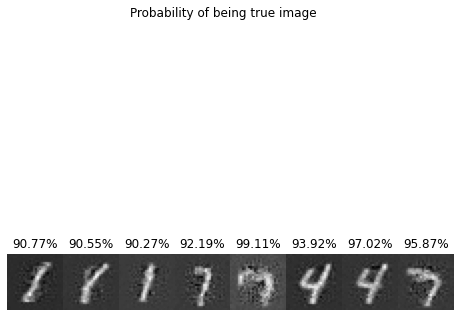

In [ ]:
if len(good_z) > 10:
  cols = 10
else:
  cols = len(good_z)

fig, ax = plt.subplots(1, cols, figsize=(8, 8))

G_model.eval()
for i in range(cols):
  
  curr_z = good_z[i]
  gen_im = G_model(curr_z)
  p = f"{round(torch.sigmoid(D_model(gen_im)).item()*100, 2)}%"
  plt.subplot(1, cols, i+1)
  plt.suptitle(f"Probability of being true image")
  plt.imshow(gen_im[0][0].cpu().detach().numpy(), cmap='gray')
  plt.title(p)
  plt.axis('off')
  # ax[1, 1].set_facecolor((0, 0, 0))
plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)
# fig.patch.set_facecolor((0, 0, 0))